In [9]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.utils import resample



In [10]:
frame_1 = pd.read_pickle('collected_patents_0-999.pkl')
frame_2 = pd.read_pickle('collected_patents_1000-1899.pkl')
frame_3 = pd.read_pickle('collected_patents_1900-7747.pkl')
frame_4 = pd.read_pickle('collected_patents_7748-9999.pkl')
frame_5 = pd.read_pickle('collected_patents_batch_5.pkl')
frame_6 = pd.read_pickle('collected_patents_batch_6.pkl')
frame_7 = pd.read_pickle('collected_patents_batch_7.pkl')
frame_8 = pd.read_pickle('collected_patents_batch_8.pkl')

all_patents = pd.concat([
    frame_1,
    frame_2,
    frame_3,
    frame_4,
    frame_5,
    frame_6,
    frame_7,
    frame_8
], ignore_index=True)

display(all_patents)


,year,patent,name_of_patenter,country,doc_number,IPCR,applicant/inventor
0,1782,Steam engines,[WATT JAMES [GB]],GB,178201321,[],inventor
1,1784,Fire and steam engines,[WATT JAMES [GB]],GB,178401432,[],inventor
2,1785,None,None,GB,178501470,[],None
3,1786,None,None,GB,178601565,[],None
4,1787,None,None,GB,178701616,[],None
...,...,...,...,...,...,...,...
25410,1919,СПОСІБ ВИГОТОВЛЕННЯ ТЕРМОЧУТЛИВИХ ЕЛЕМЕНТІВ ІЗ...,"[BONDAR VOLODYMYR YOSYPOVYCH [UA], DANILCHENKO...",CH,82640,[],inventor
25411,1919,MEJORAS EN EXTRACCIÓN DE LITIO,"[JARIWALA ANKUR D [NL], SAMS GARY W [NL], JARI...",GB,123331,"[B01D 15/ 18 A I, B01D 15/ ...",inventor
25412,1919,Insole for feet with bunions (Machine-translat...,"[OLIVELLA GARCIA ELENA [ES], OLIVELLA GARCIA, ...",US,1305171,[A61F 5/ 10 A I],inventor
25413,1919,None,None,US,1305195,[],None


In [11]:
role_counts = all_patents.groupby(['year', 'applicant/inventor']).size().unstack(fill_value=0)
#print(role_counts)

In [12]:
# Define the mapping dictionary
ipc_section_mapping = {
    'A': 'Human Necessities',
    'B': 'Performing Operations; Transporting',
    'C': 'Chemistry; Metallurgy',
    'D': 'Textiles; Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering; Lighting; Heating; Weapons',
    'G': 'Physics',
    'H': 'Electricity'
}

# Function to map IPC codes to main categories
def map_ipc_to_main_category(ipc_codes):
    main_categories = []
    for code in ipc_codes:
        section = code.strip()[0]  # Extract the first letter
        category = ipc_section_mapping.get(section, 'Unknown')
        main_categories.append(category)
    return main_categories

# Apply the function to your DataFrame
all_patents['Main_Categories'] = all_patents['IPCR'].apply(map_ipc_to_main_category)


In [13]:
display(all_patents)

,year,patent,name_of_patenter,country,doc_number,IPCR,applicant/inventor,Main_Categories
0,1782,Steam engines,[WATT JAMES [GB]],GB,178201321,[],inventor,[]
1,1784,Fire and steam engines,[WATT JAMES [GB]],GB,178401432,[],inventor,[]
2,1785,None,None,GB,178501470,[],None,[]
3,1786,None,None,GB,178601565,[],None,[]
4,1787,None,None,GB,178701616,[],None,[]
...,...,...,...,...,...,...,...,...
25410,1919,СПОСІБ ВИГОТОВЛЕННЯ ТЕРМОЧУТЛИВИХ ЕЛЕМЕНТІВ ІЗ...,"[BONDAR VOLODYMYR YOSYPOVYCH [UA], DANILCHENKO...",CH,82640,[],inventor,[]
25411,1919,MEJORAS EN EXTRACCIÓN DE LITIO,"[JARIWALA ANKUR D [NL], SAMS GARY W [NL], JARI...",GB,123331,"[B01D 15/ 18 A I, B01D 15/ ...",inventor,"[Performing Operations; Transporting, Performi..."
25412,1919,Insole for feet with bunions (Machine-translat...,"[OLIVELLA GARCIA ELENA [ES], OLIVELLA GARCIA, ...",US,1305171,[A61F 5/ 10 A I],inventor,[Human Necessities]
25413,1919,None,None,US,1305195,[],None,[]


In [14]:
# Only keep rows where Main_Categories is a non-empty list
df_labeled = all_patents[
    all_patents['Main_Categories'].apply(lambda x: isinstance(x, list) and len(x) > 0) & 
    all_patents['patent'].notna()
].copy()

df_labeled = df_labeled[df_labeled['patent'].str.split().apply(len) >= 3]
df_labeled = df_labeled.drop_duplicates(subset='patent')

# Use the first general category as the label
df_labeled['label'] = df_labeled['Main_Categories'].apply(lambda x: x[0])
df_labeled['patent'] = df_labeled['patent'].astype(str)

# Encode labels
label_encoder = LabelEncoder()
df_labeled['label'] = label_encoder.fit_transform(df_labeled['label'])

# --------------------------- OVERSAMPLING STEP ---------------------------
# Split dataset by label
dfs = [df_labeled[df_labeled['label'] == i] for i in df_labeled['label'].unique()]
max_class_size = max(len(d) for d in dfs)

df_oversampled = pd.concat([
    resample(d, replace=True, n_samples=max_class_size, random_state=42)
    for d in dfs
])

# Shuffle to mix the oversampled data
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

# ------------------------------------------------------------------------

# Split the oversampled data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_oversampled['patent'].tolist(),
    df_oversampled['label'].tolist(),
    test_size=0.2,
    stratify=df_oversampled['label']
)


# Loading a multilingual BERT tokenizer to deal with the multilingual nature of the data names
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize the training and testing text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class PatentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create the dataset instances
train_dataset = PatentDataset(train_encodings, train_labels)
test_dataset = PatentDataset(test_encodings, test_labels)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', 
    num_labels=len(set(train_labels))
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',           # Output directory
    num_train_epochs=7,               # Number of epochs
    per_device_train_batch_size=96,   # Increased batch size
    per_device_eval_batch_size=96,    # Increased batch size
    gradient_accumulation_steps=2,
    fp16=True,
    warmup_steps=500, 
    weight_decay=0.01,  
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",   
    save_strategy="epoch",  
    load_best_model_at_end=True,
    metric_for_best_model="f1",   # Use F1 score for best model
    learning_rate=1e-5,           # Set learning rate
    lr_scheduler_type="cosine",
)


# Set up the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
display(df_oversampled)

,year,patent,name_of_patenter,country,doc_number,IPCR,applicant/inventor,Main_Categories,label
0,1915,Improvements in or relating to Apparatus for P...,"[LINOTYPE MACHINERY LTD [GB], THOMAS ROBERT GI...",GB,191417410,[B41F 13/ 46 A I],applicant,[Performing Operations; Transporting],5
1,1880,Tubular aerator with filling,"[KALENIK MAREK [PL], MORAWSKI DARIUSZ [PL], KA...",US,235924,"[C02F 1/ 74 A I, B01F 3/ ...",inventor,"[Chemistry; Metallurgy, Performing Operations;...",0
2,1912,"Improvements in Dyeing, Scouring, or Washing M...","[FROHLICH CHARLES [US], CHARLES FROHLICH]",GB,191116071,[D06B 3/ 08 A I],inventor,[Textiles; Paper],7
3,1917,PHOTOGRAPHIC PROCESSING APPARATUS.,"[TAYLOR NICHOLAS JOHN [US], SKYE DAVID ALBERT ...",GB,105295,"[G03D 3/ 00 A I, G03D 3/ ...",inventor,"[Physics, Physics, Physics, Physics]",6
4,1905,СИСТЕМА РЕГУЛИРОВАНИЯ ПОДАЧИ ТОПЛИВА В ГАЗОТУР...,"[Ворончихин Н.И.,, Савченко В.Я.,, Юминов В.Г.]",US,799561,[F02C 9/ 28 A I],inventor,[Mechanical Engineering; Lighting; Heating; We...,4
...,...,...,...,...,...,...,...,...,...
23379,1867,МЕТАТЕЛЕН (СТАРТОВ) ЗАРЯД,"[GUSHLEV STRAHIL [BG], GUSHLEVA GALINA [BG], Г...",US,62830,"[F41F 3/ 04 A I, F41F 3/ 0...",inventor,[Mechanical Engineering; Lighting; Heating; We...,4
23380,1889,Modified fibers based on synthetic and/or natu...,"[SWINAREW ANDRZEJ [PL], GOLBA SYLWIA [PL], FLA...",US,403325,[D01F 1/ 10 A I],inventor,[Textiles; Paper],7
23381,1904,Double return panel system,"[SIMONSEN DAVID, Simonsen, David]",US,768236,"[E04F 13/ 07 A I, E04F 13/ ...",inventor,"[Fixed Constructions, Fixed Constructions, Fix...",2
23382,1917,CONTACT MAGNETIC RECORDING DISK FILE WITH IMPR...,"[ROBERT EDWARD FONTANA JR [US], CELIA ELIZABET...",GB,111261,"[G11B 5/ 10 A I, G11B 5/ 1...",inventor,"[Physics, Physics, Physics, Physics, Physics, ...",6


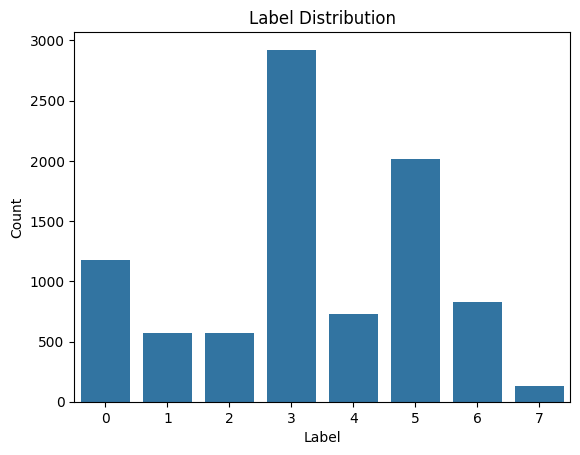

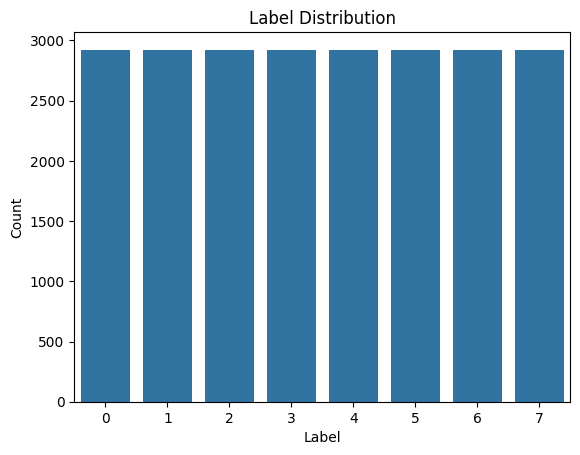

In [17]:
label_counts = df_labeled['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

label_counts = df_oversampled['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

In [18]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.084600,2.016860,0.233269,0.204689,0.207185,0.233269
2,1.988800,1.805755,0.338892,0.312644,0.319455,0.338892
3,1.731700,1.470899,0.469746,0.433544,0.454207,0.469746
4,1.417500,1.208698,0.570451,0.540596,0.559261,0.570451
5,1.162300,0.986821,0.646996,0.624560,0.651290,0.646996
6,0.776500,0.749818,0.754544,0.745358,0.747281,0.754544


TrainOutput(global_step=679, training_loss=1.4145638798754416, metrics={'train_runtime': 504.0457, 'train_samples_per_second': 259.796, 'train_steps_per_second': 1.347, 'total_flos': 1.7198837334514368e+16, 'train_loss': 1.4145638798754416, 'epoch': 6.933333333333334})

In [19]:
trainer.evaluate()


{'eval_loss': 0.7498181462287903,
 'eval_accuracy': 0.7545435107975198,
 'eval_f1': 0.7453579498837161,
 'eval_precision': 0.7472805264475834,
 'eval_recall': 0.7545435107975198,
 'eval_runtime': 3.1721,
 'eval_samples_per_second': 1474.43,
 'eval_steps_per_second': 15.447,
 'epoch': 6.933333333333334}

In [20]:
from sklearn.metrics import classification_report

# Run evaluation
preds_output = trainer.predict(test_dataset)

# Get predictions and true labels
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids

# Show per-class metrics
print(classification_report(y_true, y_pred, digits=3, zero_division=0, target_names=label_encoder.classes_))


                                                    precision    recall  f1-score   support

                             Chemistry; Metallurgy      0.687     0.738     0.712       584
                                       Electricity      0.761     0.860     0.807       584
                               Fixed Constructions      0.779     0.926     0.846       585
                                 Human Necessities      0.721     0.538     0.616       585
Mechanical Engineering; Lighting; Heating; Weapons      0.725     0.831     0.775       585
               Performing Operations; Transporting      0.603     0.416     0.492       584
                                           Physics      0.730     0.726     0.728       585
                                   Textiles; Paper      0.972     1.000     0.986       585

                                          accuracy                          0.755      4677
                                         macro avg      0.747     0.754     0.

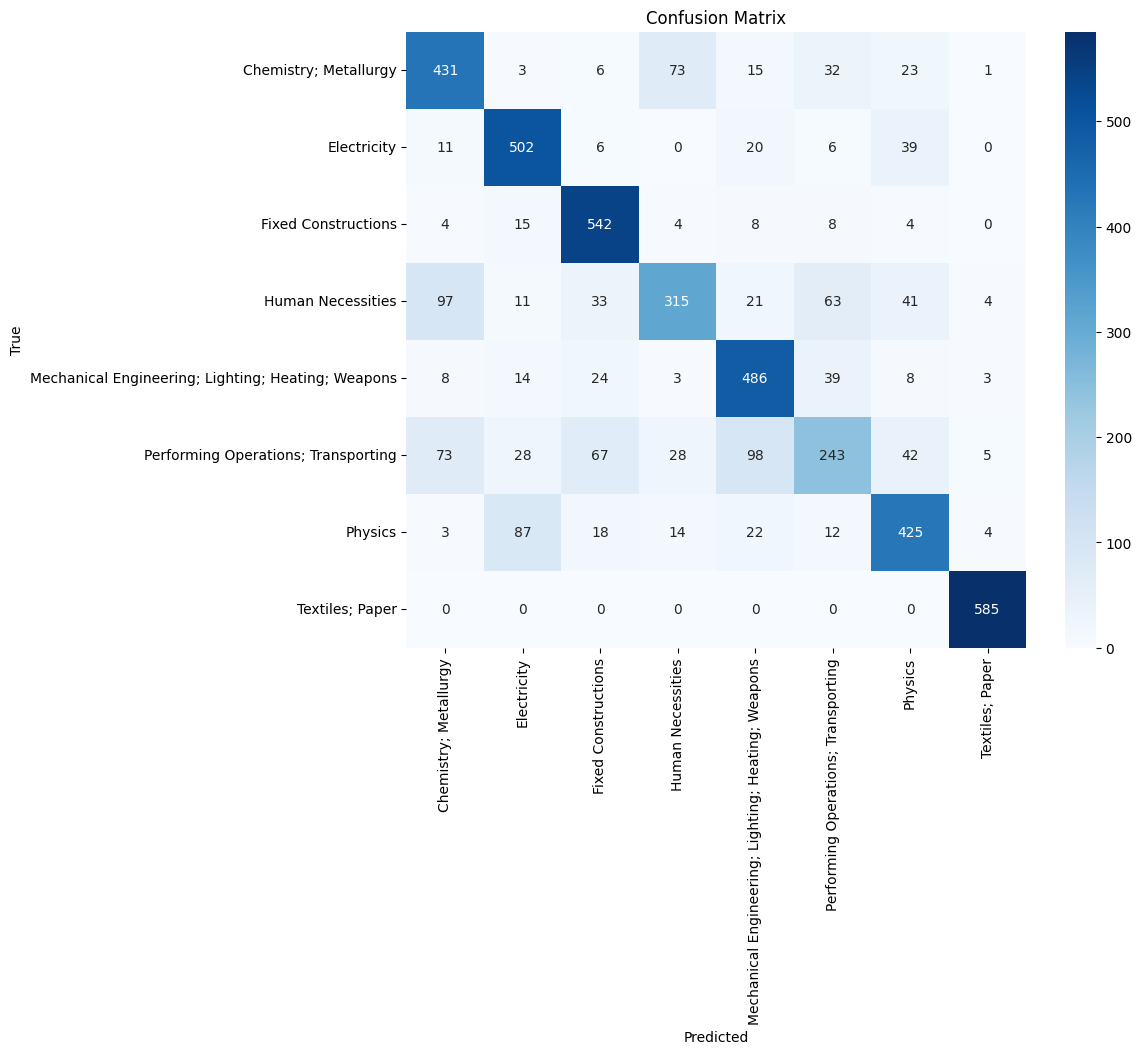

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print("Confusion Matrix:")
print(cm_df)


Confusion Matrix:
                                                    Chemistry; Metallurgy  \
Chemistry; Metallurgy                                                 431   
Electricity                                                            11   
Fixed Constructions                                                     4   
Human Necessities                                                      97   
Mechanical Engineering; Lighting; Heating; Weapons                      8   
Performing Operations; Transporting                                    73   
Physics                                                                 3   
Textiles; Paper                                                         0   

                                                    Electricity  \
Chemistry; Metallurgy                                         3   
Electricity                                                 502   
Fixed Constructions                                          15   
Human Necessities   